# 3D Plots

We start by plotting the magnetic grain using PyVista. The grain was modelled using the finite element micromagnetic software MERRILL. The grain hosts a single vortex configuration that was obtained after energy minimization.

In [1]:
import pyvista as pv
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image

In [2]:
mesh = pv.read('./Ngrains_mds/m_mult_rnd2.tec')

In [3]:
# Vector to view rough edges
cpos = [0, 0, 1]
cnorm = [-0., 0.2, 1]

# Extract a rugged volume
vol = mesh.clip(normal=cnorm, crinkle=True)
vol_nc = mesh.clip(normal=cnorm, crinkle=False)

# normals = vol_nc.extract_surface().compute_normals()
# vol_nc = vol_nc.scale((1.01, 1.01, 1.01), inplace=True)
# vol.plot(show_edges=True, cpos=cpos, show_scalar_bar=False)

In [4]:
# normals.set_active_vectors('Normals')

In [5]:
pv.rcParams['transparent_background'] = True

In [6]:
p = pv.Plotter(off_screen=True, notebook=False, window_size=[1000, 800])
p.set_background('white')


# print (f"Loading mesh: {perf_counter() - t2}")

p.add_mesh(mesh.clip(normal=cnorm, origin=mesh.center, crinkle=False, invert=False),
           show_edges=False, smooth_shading=False, show_scalar_bar=False, 
           color='grey', style='surface', opacity=0.3)

p.add_mesh(vol.clip(normal=cnorm, origin=mesh.center, crinkle=False, invert=False), 
           show_edges=True, smooth_shading=False, show_scalar_bar=False, line_width=1,
           color='coral')

p.add_mesh(vol.clip(normal=cnorm, origin=mesh.center, crinkle=False, invert=True), 
           show_edges=True, smooth_shading=True, show_scalar_bar=False, 
           color='mediumturquoise')

p.add_mesh(mesh.outline(), color='grey', opacity=1, line_width=2)

p.view_isometric()
p.camera.SetWindowCenter(0, 0)
# p.camera.zoom(1.3)
p.camera.azimuth = 80
p.camera.elevation = -15

light = pv.Light(intensity=0.6)
light.set_direction_angle(-60, 20)
p.add_light(light)
# p.enable_shadows()

p.show(screenshot='./figures/grain_OPX042_tetra.png')
# p.show(jupyter_backend='static')

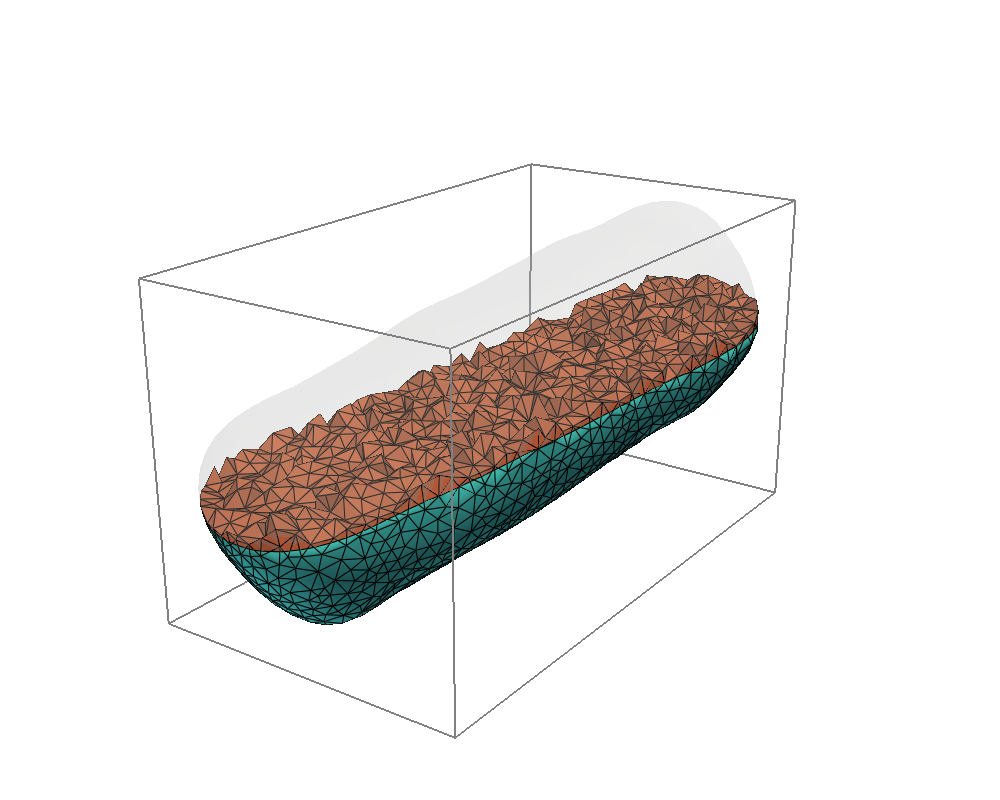

In [7]:
Image("figures/grain_OPX042_tetra.png", width=400)

In [8]:
p = pv.Plotter(off_screen=True, notebook=False, window_size=[1000, 800])
p.set_background('white')


# print (f"Loading mesh: {perf_counter() - t2}")

p.add_mesh(mesh, show_edges=False, smooth_shading=True, specular=5, show_scalar_bar=False, 
           color='lightgrey', style='surface', opacity=1)

p.add_mesh(mesh.outline(), color='grey', opacity=1, line_width=2)

p.view_isometric()
p.camera.SetWindowCenter(0, 0)
# p.camera.zoom(1.3)
p.camera.azimuth = 80
p.camera.elevation = -15

# light = pv.Light(intensity=0.3)
# light.set_direction_angle(-60, 20)
# p.add_light(light)
# p.enable_shadows()

# p.save_graphic('grain_OPX042_full.png')
p.show(screenshot='./figures/grain_OPX042_full.png')
# p.show(jupyter_backend='static')

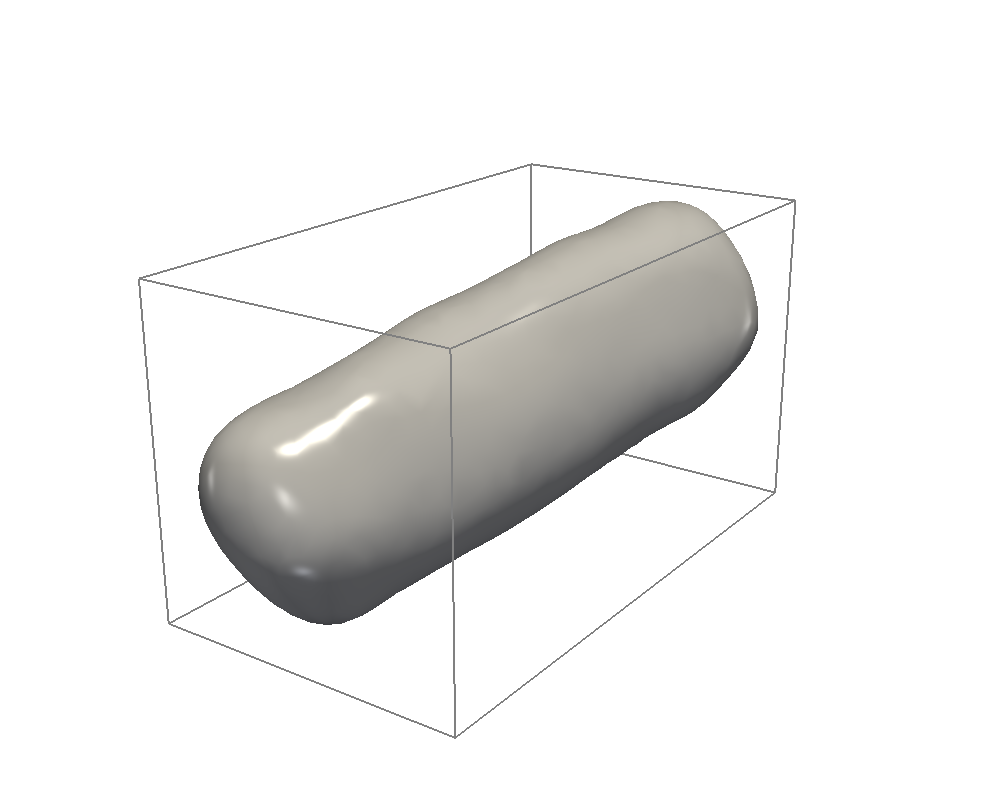

In [9]:
Image("figures/grain_OPX042_full.png", width=400)

In [10]:
mesh.point_data.update(dict(M_vec=np.column_stack((mesh.get_array('Mx'),
                                                   mesh.get_array('My'),
                                                   mesh.get_array('Mz')))))
mesh_g = mesh.compute_derivative(scalars='M_vec', vorticity=True)
mesh.point_data.update(dict(vorticity=mesh_g.get_array('vorticity')))
helicity = np.einsum('ij,ij->i', mesh.get_array('M_vec'), mesh.get_array('vorticity'))
mesh.point_data.update(dict(helicity=helicity))
contours = mesh.contour(scalars='helicity', isosurfaces=[-30, 30])
polys = pv._vtk.vtk_to_numpy(contours.GetPolys().GetData()).reshape(-1, 4)

p = pv.Plotter(off_screen=True, notebook=False, window_size=[1000, 800])
p.set_background('white')

p.add_mesh(mesh.outline(), color='grey', opacity=1, line_width=2)

p.add_mesh(contours.smooth(n_iter=100), opacity=1, style='surface', clim=[-1, 1],
           color='fc7d7b', show_scalar_bar=False, 
           smooth_shading=True, lighting=True, specular=2, specular_power=10, ambient=0.)

p.add_mesh(mesh, opacity=0.04, style='wireframe', color='grey')

# p.add_mesh(mesh.slice(normal=(0., 0., 1)).extract_feature_edges(), opacity=1, color='k',
#            line_width=1)

ms = mesh.slice(normal=(1., -0.4, 0))
arrowsm = mesh.glyph(scale=False, factor=0.02, orient="M_vec", 
                   tolerance=0.05, geom=pv.Arrow(tip_length=0.6, tip_radius=0.2)
                   )
p.add_mesh(arrowsm, cmap='RdYlBu', scalars='Mz', clim=[-1, 1], show_scalar_bar=False)

mesh.set_active_vectors('M_vec')
c = np.array(mesh.center)
streamlines, src = mesh.streamlines(vectors='M_vec', return_source=True, initial_step_length=.1,
    max_step_length=.5, n_points=60, source_radius=0.15, source_center=c, max_steps=500)
p.add_mesh(streamlines.tube(radius=0.0008), cmap='RdYlBu',
           scalars="Mz", clim=[-1, 1], # lighting=False,
           show_scalar_bar=False)


p.view_isometric()
p.camera.SetWindowCenter(0, 0)
# p.camera.zoom(1.3)
p.camera.azimuth = 80
p.camera.elevation = -15

p.save_graphic('grain_OPX042_vortex.svg')
p.show(screenshot='./figures/grain_OPX042_vortex.png')

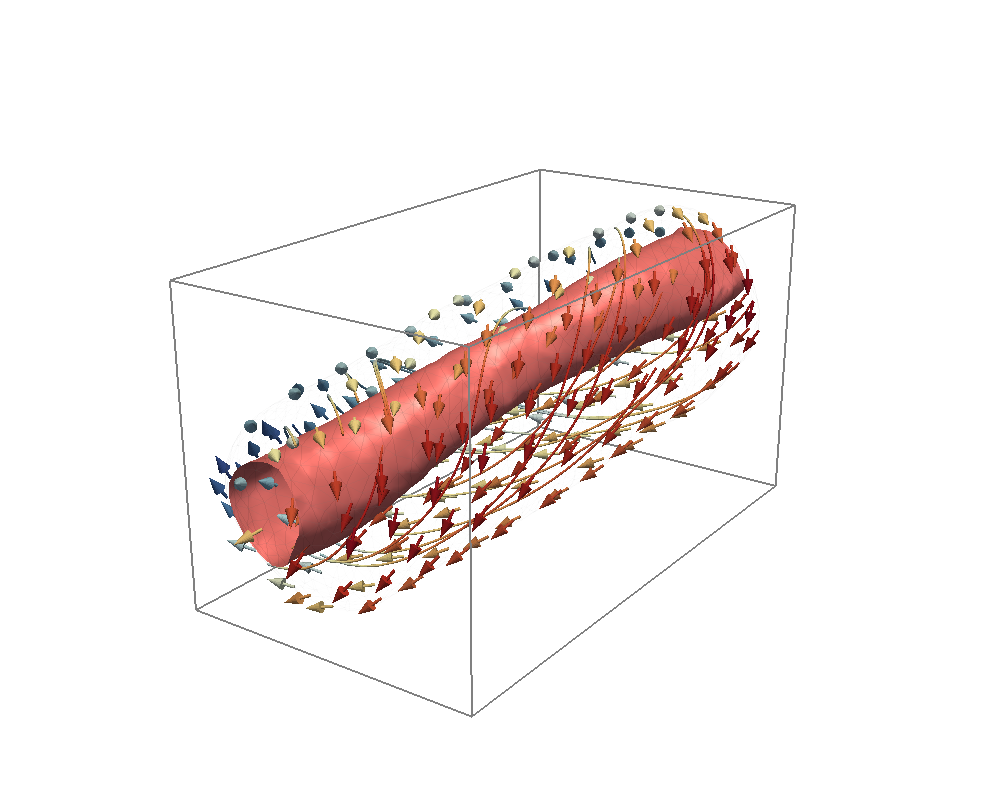

In [11]:
Image("figures/grain_OPX042_vortex.png", width=400)

In [12]:
print('PyVista mesh center:', mesh.center)

PyVista mesh center: [1.6359545, 6.1229385, 4.0270365]


# Grain signal

In this section we compute the grain signal using the `mmt_micromagnetic_demag_signature` library. The signal will be calculated at a scan surface of `3 µm x 3 µm`, at a height of `z = 1000 nm`. The grain was modelled using finite elements and the MERRILL software. The magnetic moment positions, orientations and volumes are specified in a `vbox` file. Using this information, the grain will be centered at the origin and the highest mesh point will be located at `z = 106.3 nm`. The magnetic state from the `vbox` file is a single vortex and was obtained after energy minimization using MERRILL.

In [13]:
import mmt_micromagnetic_demag_signature as mds
import numpy as np
from pathlib import Path

In [14]:
# Using the vbox file we can calculate the geometric centre/centroid of the mesh and shift
# the coordinates to the origin. Coordinates in micrometer units.
magvol = np.loadtxt('./Ngrains_mds/mag_vol_rnd2.vbox', skiprows=1)
r, vol = np.copy(magvol[:, :3]), np.copy(magvol[:, 6])
r_GC = r * vol[:, np.newaxis]
r_GC = r_GC.sum(axis=0) / vol.sum()  # geo center
r = np.subtract(r, r_GC, out=r)  # coords wrt geo center (origin = 0)
r_GC_new = (r * vol[:, np.newaxis]).sum(axis=0) / vol.sum()  # new geo center at zero
print('Geom center:', r_GC , 'µm')
print('New geom center:', r_GC_new, 'µm')
print('Volume:', vol.sum(), 'µm^3')
print(f'Highest magnetic moment position: {r[:, 2].max():.4f} µm')
# Magnetic moment
# 482477.0 * vol.sum()

Geom center: [1.63410632 6.12897374 4.0302677 ] µm
New geom center: [-2.48467257e-17  7.12927062e-15 -6.10242038e-16] µm
Volume: 0.004941232769839 µm^3
Highest magnetic moment position: 0.1063 µm


Now we specify the scan grid limits using the sensor centers, and compute the magnetic signal of the vortex state at the height of 1000 nm.

In [15]:
# Creating scan grid
nm, µm = 1e-9, 1e-6

scan_spacing = (10 * nm, 10 * nm)
scan_limits = np.array([[-1.5, -1.5], [1.5, 1.5]]) * µm

FILE_energy = Path('./Ngrains_mds/grain_OPX042_rnd2.log')
HEIGHT = 1000
FNAME =  f'./Ngrains_mds/scan_signal_rnd2_scan-height_{HEIGHT}nm.npy'
VBOX = './Ngrains_mds/mag_vol_rnd2.vbox'
HLABEL = 'h' + str(HEIGHT)

scan_height = HEIGHT * nm
# print(f'Random state = {RAN} ScanH = {HEIGHT} nm')
demag_signal = mds.MicroDemagSignature(scan_limits, scan_spacing, scan_height,
                                       VBOX, FILE_energy)

demag_signal.read_input_files(origin_to_geom_center=True)
demag_signal.compute_scan_signal(method='cython')

signal_array = np.copy(demag_signal.Bz_grid)

np.save(FNAME, signal_array)

In [16]:
print("Top z coordinate:", demag_signal.z.max() * 1e6)

Top z coordinate: 0.10629329960955422


In [17]:
dSx = (demag_signal.Sx[1] - demag_signal.Sx[0]) * 1e6
dSy = (demag_signal.Sy[1] - demag_signal.Sy[0]) * 1e6
extents = [-1.5 - dSx * 0.5, 1.5 + dSx * 0.5,
           -1.5 - dSy * 0.5, 1.5 + dSy * 0.5]

## Plots

In [18]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas
from matplotlib.patheffects import Stroke, Normal
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
import matplotlib.patheffects as PathEffects

In [19]:
plt.style.use('./adornmyplot_large.mplstyle')

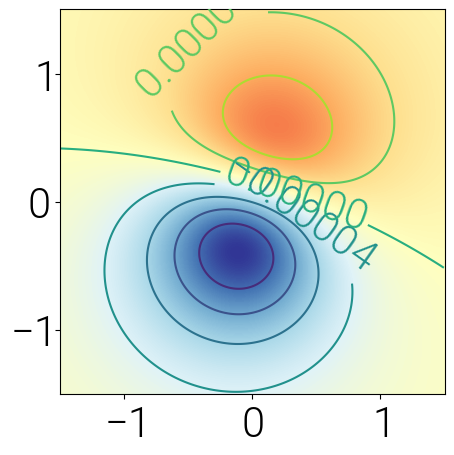

In [20]:
plt.figure(figsize=(5, 5))
vlim = np.abs(signal_array.min())
plt.imshow(signal_array, origin='lower', cmap='RdYlBu_r', clim=[-vlim, vlim], extent=extents)
c = plt.contour(signal_array, origin='lower', extent=extents)
plt.clabel(c)
plt.show()

In [21]:
print("Max signal intensity:", np.max(np.abs(signal_array)) * 1e6) 

Max signal intensity: 194.03400860273314


In [22]:
Z = signal_array * 1e6
# vlim = np.max(np.abs(Z))
vlim = 150

n = 10  # Number of levels
dz = (Z.max() - Z.min()) / n
levels = np.linspace(Z.min(), Z.max(), n, endpoint=True)
# Add a zero at the middle
levels = np.insert(levels, np.where(levels > 0)[0][0], 0.0)
cmap = plt.get_cmap("RdBu_r")


def drop_shadow(Z, l0, l1, sigma=5, alpha=0.5):
    """Compute the drop shadow for a contour between l0 and l1.
    This works by first:
    1. render the contour in black using an offline image
    2. blue the contour using a Guassian filter
    3. set the alpha channel accordingly
    """
    fig = plt.Figure(figsize=(5, 5))
    canvas = FigureCanvas(fig)
    ax = fig.add_axes([0, 0, 1, 1], frameon=False)
    ax.contourf(
        Z,
        # vmin=Z.min(), vmax=Z.max(),
        vmin=-vlim, vmax=vlim,
        levels=[l0, l1],
        origin="lower",
        colors="black",
        extent=[-1, 1, -1, 1],
        )
    ax.set_xlim(-1, 1), ax.set_ylim(-1, 1)
    canvas.draw()
    A = np.array(canvas.renderer.buffer_rgba())[:, :, 0]
    del fig
    A = gaussian_filter(A, sigma)
    A = (A - A.min()) / (A.max() - A.min())
    I = np.zeros((A.shape[0], A.shape[1], 4))
    I[:, :, 3] = (1 - A) * alpha
    return I

# # Contours to do the labeling
# fig = plt.figure(figsize=(5, 5))
# ax = fig.add_axes([0, 0, 1, 1], frameon=True)
# cfLab = ax.contour(Z, vmin=-vlim, vmax=vlim, levels=levels, origin="lower",
#                    cmap=cmap, extent=[-1.5, 1.5, -1.5, 1.5], zorder=zorder)
# cLab = ax.clabel(cfLab, cfLab.levels[:-1], inline=1, colors='k', zorder=100, fmt="%.1f")
# cTexts = [c for c in cLab]
# del fig
# # del cLab
# del cfLab

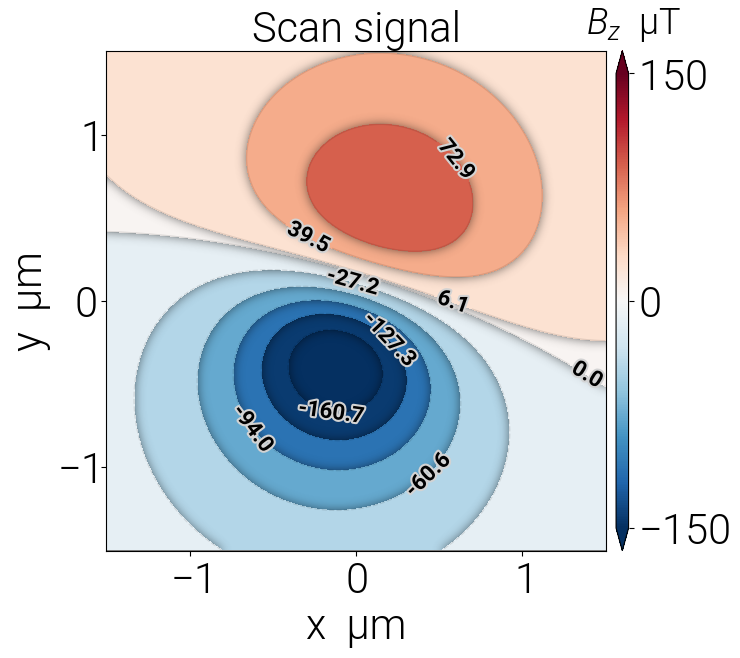

In [23]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0, 0, 1, 1], frameon=True)

conts = []
zorder = -100
for i in range(len(levels) - 1):
    l0, l1 = levels[i], levels[i + 1]
    I = drop_shadow(Z, l0, l1)
    ax.imshow(I,
              extent=extents,
              origin="upper", zorder=zorder,
              clim=[-vlim, vlim]
              )
    zorder += 1
    cf = ax.contourf(
        Z,
        # vmin=Z.min(),
        # vmax=Z.max(),
        vmin=-vlim, vmax=vlim,
        levels=[l0, l1],
        origin="lower",
        cmap=cmap,
        extent=extents,
        zorder=zorder,
    )
    # ax.text(0.5, 0.5, 'AAAAAA', zorder=zorder)
    # conts.append(cf)
    # ax.clabel(cf, [l0], inline=0, colors='k', zorder=100, fmt="%.1f")
    zorder += 1
    
# for c in cTexts:
#     ax.text(*c.get_position(), c.get_text(), color='k', zorder=100, rotation=c.get_rotation())

cfLab = ax.contour(Z, vmin=-vlim, vmax=vlim, levels=levels, origin="lower", linewidths=1,
                   colors='k', extent=extents, zorder=zorder, alpha=0.1)
cLab = ax.clabel(cfLab, cfLab.levels[:-1], inline=1, colors='k', zorder=100, fmt="%.1f",
                 fontsize=16)
for c in cLab: 
        c.set_fontweight('bold')
        c.set_alpha(1.)
        # clab.set_color('darkgrey')
        c.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='lightgrey')])

# COLORBAR
axL = ax.get_position()
axcb = fig.add_axes([axL.x1 + 0.02, axL.y0, 0.025, axL.height])
cb = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=-vlim, vmax=vlim), cmap='RdBu_r'), 
                  cax=axcb, orientation='vertical', # shrink=0.7, aspect=10, # pad=-0.8
                  extend='both')
cb.ax.xaxis.set_ticks_position('top')
cb.set_ticks((-vlim, 0, vlim))
cb.set_label(r'$B_{z}$' + '  µT', fontsize=26, y=1.15, rotation=0, labelpad=-70)

ax.set_xlabel('x  µm')
ax.set_ylabel('y  µm')
ax.set_title('Scan signal')

#### plt.savefig("../../figures/showcases/contour-dropshadow.png", dpi=600)
plt.savefig("figures/grain_OPX042_signal_H.svg", dpi=300, bbox_inches='tight')
plt.show()

# Multipole Inversion

In this section we perform a multipole inversion of the modelled magnetic signal:

In [24]:
import json
import mmt_multipole_inversion as minv

The scan signal was computed at a distance z = 1000 nm

In [25]:
nm, µm = 1e-9, 1e-6
scan_height = 1000 * nm

In [26]:
# Directory to save the files
BASE_DIR = Path('micromagFiles')
BASE_DIR.mkdir(exist_ok=True)

In [27]:
# Save the particle information in the NPZ file. Alternatively, we can
# pass these parameters to the MultipoleInversion class directly
np.savez('./Ngrains_mds/particle_vols_height-dep_NPZ_ARRAYS',
         # Bz_array=,
         # The origin is at the particle's centroid r_GC_new is practically zero
         particle_positions=np.array([np.zeros(3)]),
         volumes=np.array([vol.sum()]) * (µm ** 3)
         )

In [28]:
print(f'Saving parameters for scan position at {scan_height * 1e6:.2f} µm')

# Set dictionary
metadict = {}
metadict["Scan height Hz"] = float(scan_height)
metadict["Scan area x-dimension Sx"] = (3.01) * µm
metadict["Scan area y-dimension Sy"] = (3.01) * µm
metadict["Scan x-step Sdx"] = 10 * nm
metadict["Scan y-step Sdy"] = 10 * nm
metadict["Time stamp"] = '0000'
metadict["Number of particles"] = 1
# Notice that the origin of the scan is set at 0.0 by default thus the 
# measurement at the bottom left corner has coordinates (0, 0)
# Shifting the coordinates might have a small effect in the results
metadict["Sensor origin x"] = -1.5 * µm
metadict["Sensor origin y"] = -1.5 * µm

with open(f'./Ngrains_mds/PARAMETERS_scan-height_1000nm.json', 'w') as f:
    json.dump(metadict, f)

Saving parameters for scan position at 1.00 µm


In [29]:
# Perform the inversion for the given ran state, order and scan H
grain_inv = minv.MultipoleInversion(
    './Ngrains_mds/PARAMETERS_scan-height_1000nm.json',
    './Ngrains_mds/particle_vols_height-dep_NPZ_ARRAYS.npz',
    expansion_limit='octupole',
    sus_functions_module='spherical_harmonics_basis',
    verbose=False
    )

# Load the scan signal data from the NPY file
grain_inv.Bz_array = np.load(f'./Ngrains_mds/scan_signal_rnd2_scan-height_1000nm.npy')

grain_inv.compute_inversion(method='sp_pinv', rcond=1e-25)

In [30]:
with np.printoptions(precision=2):
    print('Dipole moments:    ', grain_inv.inv_multipole_moments[:, :3])
    print('Quadrupole moments:', grain_inv.inv_multipole_moments[:, 3:8])
    print('Octupole moments:  ', grain_inv.inv_multipole_moments[:, 8:])
    
    M = grain_inv.inv_multipole_moments[0][:3] / grain_inv.volumes[0]
    print('\nMagnetization:', M)
    print('|Magnetization|:', np.linalg.norm(M))

Dipole moments:     [[ 4.96e-16  1.60e-15 -4.36e-16]]
Quadrupole moments: [[1.11e-23 5.91e-26 3.55e-23 2.22e-23 1.78e-24]]
Octupole moments:   [[ 2.34e-29 -1.02e-29 -3.33e-29  2.78e-29 -1.70e-29 -4.48e-29 -3.73e-29]]

Magnetization: [100290.57 323803.11 -88282.88]
|Magnetization|: 350286.3436722771


We can compute the expected values of the dipole moments and magnetization using the magnetization:

In [31]:
magnetite_Ms_roomT = 482477.0
mdata = np.loadtxt('./Ngrains_mds/mag_vol_rnd2.vbox', skiprows=1, ndmin=2, usecols=[3, 4, 5, 6])
# Volume
vols = mdata[:, 3] * 1e-18
tot_vol = np.sum(vols)
# Total dipole moment summing all nodes weighted by eff volume
dipmom_total = magnetite_Ms_roomT * np.sum(vols[:, np.newaxis] * mdata[:, :3], axis=0)
mag_total_scaled = (np.linalg.norm(dipmom_total) / tot_vol) / magnetite_Ms_roomT

In [32]:
print('Expected dipole moments:', dipmom_total)
print('Expected magnetization:', np.linalg.norm(dipmom_total) / tot_vol)

Expected dipole moments: [ 4.95834223e-16  1.60113248e-15 -4.35587739e-16]
Expected magnetization: 350484.1454326961
